(np.float64(-0.5), np.float64(1199.5), np.float64(629.5), np.float64(-0.5))

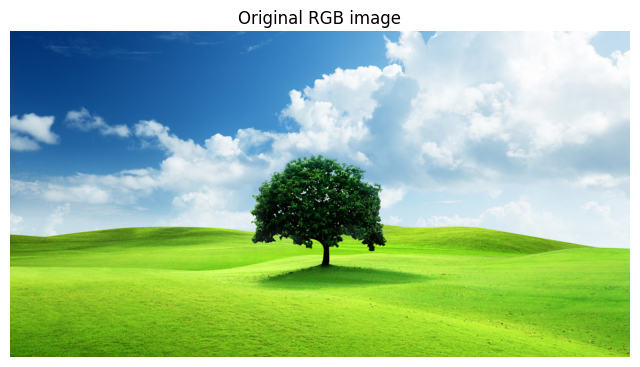

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
img_path = 'img.jpg'
img_bgr = cv2.imread(img_path)
if img_bgr is None:
    raise FileNotFoundError(f'Image not found: {img_path}')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,6))
plt.imshow(img_rgb)
plt.title('Original RGB image')
plt.axis('off')

(np.float64(-0.5), np.float64(1199.5), np.float64(629.5), np.float64(-0.5))

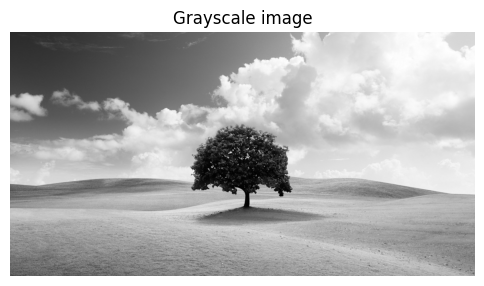

In [2]:
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(6,6))
plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale image')
plt.axis('off')

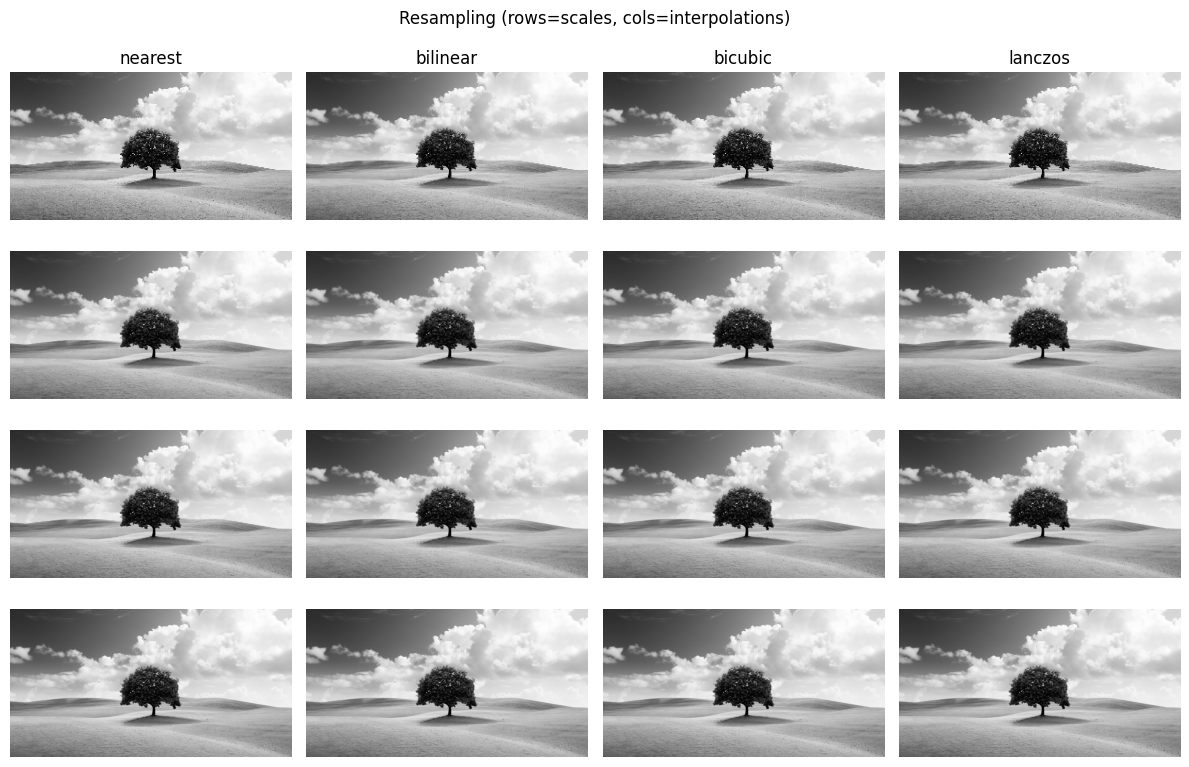

In [3]:
def resample(img, fx, fy, interp):
    return cv2.resize(img, None, fx=fx, fy=fy, interpolation=interp)
scales = [0.25, 0.5, 0.75, 1.0]
interps = {
    'nearest': cv2.INTER_NEAREST,
    'bilinear': cv2.INTER_LINEAR,
    'bicubic': cv2.INTER_CUBIC,
    'lanczos': cv2.INTER_LANCZOS4
}
resampled = {}
for name, method in interps.items():
    resampled[name] = [resample(img_gray, s, s, method) for s in scales]
plt.figure(figsize=(12,8))
for i, s in enumerate(scales):
    for j, name in enumerate(interps.keys()):
        plt.subplot(len(scales), len(interps), i*len(interps)+j+1)
        plt.imshow(resampled[name][i], cmap='gray')
        if i == 0:
            plt.title(name)
        plt.axis('off')
plt.suptitle('Resampling (rows=scales, cols=interpolations)')
plt.tight_layout()

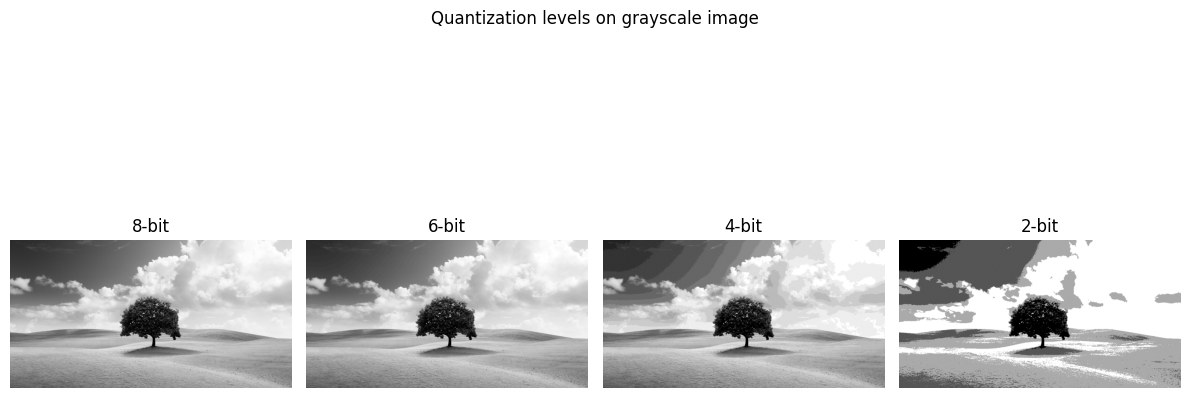

In [4]:
def quantize(img, bits):
    levels = 2 ** bits
    img_norm = img.astype(np.float32) / 255.0
    img_q = np.floor(img_norm * levels) / (levels - 1)
    img_q = np.clip(img_q, 0, 1)
    return (img_q * 255).astype(np.uint8)
bits_list = [8, 6, 4, 2]
plt.figure(figsize=(12,6))
for i, b in enumerate(bits_list):
    img_q = quantize(img_gray, b)
    plt.subplot(1, len(bits_list), i+1)
    plt.imshow(img_q, cmap='gray')
    plt.title(f'{b}-bit')
    plt.axis('off')
plt.suptitle('Quantization levels on grayscale image')
plt.tight_layout()

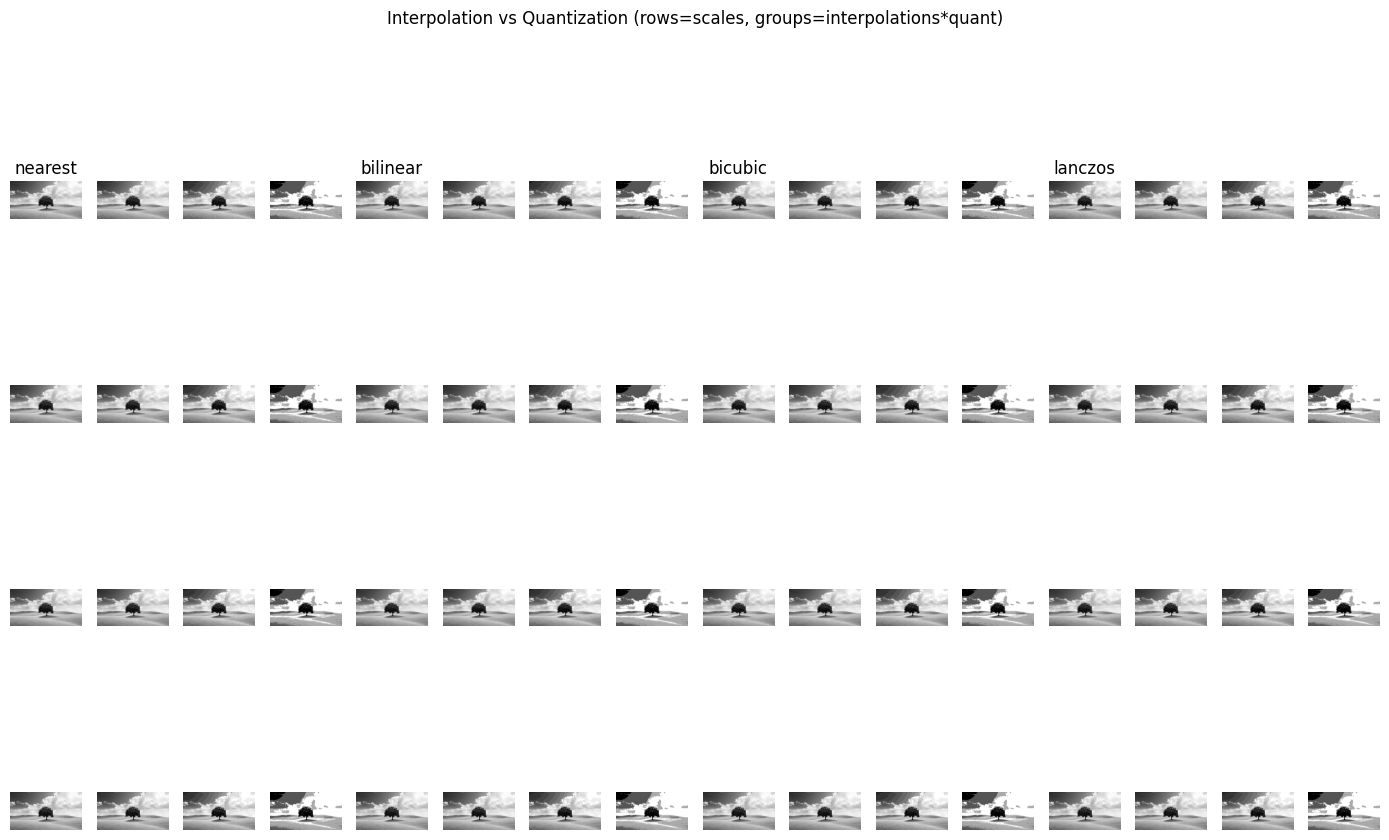

In [5]:
plt.figure(figsize=(14,10))
rows = len(scales)
cols = len(interps) * len(bits_list)
for i, s in enumerate(scales):
    for j, name in enumerate(interps.keys()):
        img_r = resampled[name][i]
        for k, b in enumerate(bits_list):
            idx = i*cols + j*len(bits_list) + k + 1
            plt.subplot(rows, cols, idx)
            img_q = quantize(img_r, b)
            plt.imshow(img_q, cmap='gray')
            if i == 0 and k == 0:
                plt.title(name)
            if j == 0 and k == 1:
                plt.ylabel(f'scale={s}')
            plt.axis('off')
plt.suptitle('Interpolation vs Quantization (rows=scales, groups=interpolations*quant)')
plt.tight_layout()

Artifacts observed at lower sampling and quantization levels:
- At low sampling (small scales) aliasing, blurring, and loss of detail appear; nearest introduces blockiness, bilinear smooths, bicubic preserves edges better, and lanczos can produce ringing near high-contrast edges.
- At low quantization (2-4 bits) posterization and banding occur; smooth gradients break into visible steps and fine texture/detail are lost.
Which degrades image quality more and why:
- Low sampling resolution generally degrades perceived image quality more than low quantization because spatial detail and high-frequency content are permanently lost when resolution is reduced; no amount of quantization precision can recover those lost spatial details.
- Low quantization affects tonal resolution and introduces banding, but structural shapes and edges remain visible if sampling is sufficient.
How these concepts affect image compression or transmission:
- Low sampling reduces the number of pixels, which directly lowers bitrate and makes compression much more effective, but at the cost of lost detail.
- Low quantization (fewer bits per pixel) reduces amplitude precision, reducing file size but causing visible banding and loss of subtle gradients.
- In lossy compression both sampling and quantization are exploited: transform codecs discard high-frequency components (effectively reducing sampling for those frequencies) and quantize transform coefficients to fewer bits.
- For transmission, reducing sampling resolves bandwidth constraints but increases need for error-resilient upscaling; lowering quantization reduces bitrate but may require dithering to reduce banding.